# Notebook Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Update OpenCV

Define Local Path

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', 'CW_Dataset', 'FaceDetectionTrain.ipynb', 'test_functions.ipynb', 'Best_SIFT_SVM.pkl', 'Best_HOG_SVM.pkl', 'Best_HOG_MLP.pkl', 'Test_Emotion_Recognition_Video_SVM_MLP.ipynb', 'Y2Mate.is - Emotional Range of a Teaspoon  Harry Potter and the Order of the Phoenix-r94aUPdPgzk-720p-1652383451821.mp4', 'FERVideoTest.mp4', 'cnn_model.pkl', 'vgg16_model.pkl', 'elon.mp4', 'kid.mp4', 'Untitled0.ipynb', 'Test_Emotion_Recognition_Video_CNN.ipynb', 'CNNmodel.ipynb']


Copy and Unzip the dataset directly on the Colab server, which will make accessing the data much faster.

In [ ]:
#Using Lab 07 code and changing the zipped folder name 
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

# Import Packages

In [ ]:
import cv2
import time
from PIL import Image
import os

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, learning_curve
from sklearn import svm, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import recall_score, roc_auc_score, precision_score, roc_curve, auc

from skimage import img_as_ubyte, io, color
from skimage.feature import hog
from skimage import data, exposure

from imblearn.combine import SMOTEENN 
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import random
import pickle
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import torch.optim as optim
from torch.optim import lr_scheduler
import cv2
from google.colab.patches import cv2_imshow

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
%matplotlib inline

cuda:1


In [ ]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5 MB 90 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Load Data

# CNN

In [ ]:
#Adapted from the below link :
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


#Custom Dataset class to load training and testing images

class ImageDataLoader(Dataset):

  def __init__(self, df, root_dir, transform = None):
    """
        Args:
            df (string): Dataframe in which the train or test text files are loaded.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.df = df
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    #Returns the size of the dataset.
    return len(self.df)

  def __getitem__(self, idx):
    #__getitem__ to support the indexing such that dataset[i] can be used to get iith sample.
    #This function is used to read the images as opposed to the above functions where the contents of folder and the label text files were read.
    if torch.is_tensor(idx):
      idx = idx.tolist()

    image_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
    image = Image.open(image_path) #Storing the image 
    label = self.df.iloc[idx, 1] #Storing the label

    if self.transform:
      #Applying torchvision image transformations 
      image = self.transform(image)
    

    return image, label
  


In [ ]:
# Creating the test and trian path

train_txt_path = "/content/labels/list_label_train.txt"
test_txt_path = "/content/labels/list_label_test.txt"

col_names = ["Image_filename", "Label"]
train_df = pd.read_csv(train_txt_path, names = col_names, header = None, delim_whitespace = True)
test_df = pd.read_csv(test_txt_path, names = col_names, header = None, delim_whitespace = True)

# Removing .jpg first and then adding _aligned.jpg to the image names so that they match with the names in the train and test directory

train_df["Image_filename"] = train_df["Image_filename"].apply(lambda i: i[:-4])
test_df["Image_filename"] = test_df["Image_filename"].apply(lambda i: i[:-4])
train_df["Image_filename"] = train_df["Image_filename"] + "_aligned.jpg"
test_df["Image_filename"] = test_df["Image_filename"] + "_aligned.jpg"

In [ ]:
#Code taken from Lab 08
#The transformations are applied one after the other, sequentially, using the method transforms.Compose().
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Transforming the PILImage images of range [0, 1] to Tensors of normalized range [-1, 1]

In [ ]:
# Loading images using the custom ImageDataLoader
train_path = "/content/train"
test_path = "/content/test"

train_images = ImageDataLoader(df = train_df, root_dir = train_path, transform = transform)

test_images = ImageDataLoader(df = test_df,root_dir = test_path, transform = transform)

trainsetLoader = torch.utils.data.DataLoader(train_images, batch_size=64,
                                          shuffle=True, num_workers=2)


testsetLoader = torch.utils.data.DataLoader(test_images, batch_size=64,
                                         shuffle=False, num_workers=2)

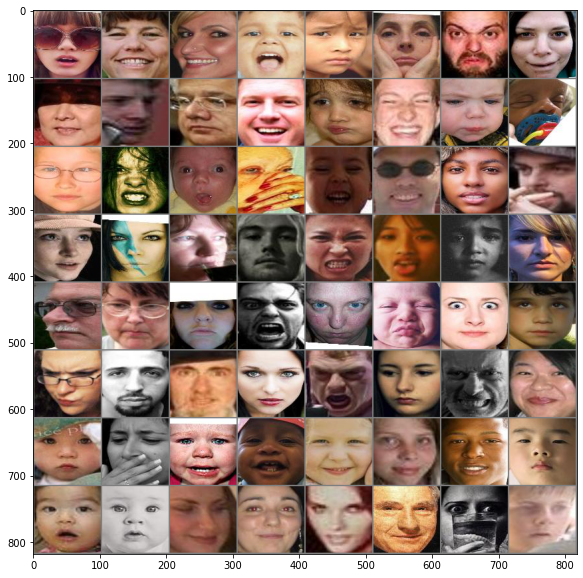

Ground-truth: tensor([1, 4, 4, 4, 5, 5, 6, 4, 4, 5, 7, 4, 5, 4, 5, 7, 7, 6, 1, 5, 4, 4, 4, 7,
        4, 7, 7, 7, 6, 4, 5, 7, 7, 7, 7, 6, 6, 5, 1, 7, 3, 7, 4, 7, 6, 5, 6, 4,
        7, 5, 5, 4, 4, 4, 4, 7, 1, 1, 4, 4, 4, 4, 2, 1])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize: back to range [0, 1] just for showing the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))     # Reshape: C, H, W -> H, W, C
    plt.show()


# get some random training images
dataiter = iter(trainsetLoader)
images, labels = dataiter.next()

# show images and print labels
fig = plt.subplots(1, 1, figsize=(10 ,10))
imshow(torchvision.utils.make_grid(images))

print('Ground-truth:', labels)

In [ ]:
#Code taken from the below tutorial link :
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py



class Net(nn.Module):
    def __init__(self, num_classes=8):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1), #creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs
            nn.BatchNorm2d(6), #helps by making the data flowing between intermediate layers of the neural network look, we can avoid using dropout as this has regularisation effect
            nn.ReLU(inplace=True), #Non Linear Activation Function
            nn.MaxPool2d(kernel_size=2, stride=2), #to reduce the dimensions of the feature maps, downsample the input by taking the max value in the window

            # Defining another 2D convolution layer
            nn.Conv2d(6, 12, kernel_size=3, stride=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Defining another 2D convolution layer
            nn.Conv2d(12, 6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.linear_layers = nn.Sequential(
            nn.Linear(6 * 12 * 12, 120),
            nn.Linear(120, num_classes)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x






In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
import time

t0 = time.time()

for epoch in range(2):  # loop over the training set two times

    running_loss = 0.0
    for i, data in enumerate(trainsetLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics (loss.item() returns the mean loss in the mini-batch)
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training: total time in seconds =', time.time() - t0)

Finished Training: total time in seconds = 86.72288703918457


In [ ]:
#Training and Evaluating the model
import time
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
epochs = 50


t0 = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainsetLoader):
            net = net.cuda()

            optimizer.zero_grad()
            outputs = net(images.cuda())
            loss = criterion(outputs.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testsetLoader):

                    outputs = net(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                accuracy = 100 * correct / float(total)

                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)

                if count % 500 == 0:
                    print("Iteration Number: {} - Loss: {} -  Accuracy: {} %".format(count, loss.data, accuracy))
print('Finished Training: total time in seconds =', time.time() - t0)

Iteration Number: 500 - Loss: 0.7562510371208191 -  Accuracy: 67.66622924804688 %
Iteration Number: 1000 - Loss: 0.5624533891677856 -  Accuracy: 67.60104370117188 %
Iteration Number: 1500 - Loss: 0.6257508993148804 -  Accuracy: 68.83963012695312 %
Iteration Number: 2000 - Loss: 0.6641812324523926 -  Accuracy: 66.62320709228516 %
Iteration Number: 2500 - Loss: 0.5350619554519653 -  Accuracy: 69.42633819580078 %
Iteration Number: 3000 - Loss: 0.674860954284668 -  Accuracy: 70.63233184814453 %
Iteration Number: 3500 - Loss: 0.37123242020606995 -  Accuracy: 70.5345458984375 %
Iteration Number: 4000 - Loss: 0.4266837239265442 -  Accuracy: 69.06779479980469 %
Iteration Number: 4500 - Loss: 0.5770268440246582 -  Accuracy: 68.93741607666016 %
Iteration Number: 5000 - Loss: 0.6940727233886719 -  Accuracy: 69.06779479980469 %
Iteration Number: 5500 - Loss: 0.42160773277282715 -  Accuracy: 69.13298797607422 %
Iteration Number: 6000 - Loss: 0.39296454191207886 -  Accuracy: 68.6766586303711 %
Itera

In [ ]:
import pickle

with open("cnn_model.pkl", "wb") as f:
    pickle.dump(net, f)

In [ ]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 8.7 MB/s 


In [ ]:
#Vggface2
from facenet_pytorch import InceptionResnetV1
# For a model pretrained on VGGFace2
vggface2_model = InceptionResnetV1(pretrained='vggface2')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggface2_model.parameters(), lr=0.001)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
#Training and Evaluating the Vggface2 model
import time

count = 0
vggface2_model_loss_list = []
vggface2_model_iteration_list = []
vggface2_model_accuracy_list = []
epochs = 50


t0 = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainsetLoader):
            vggface2_model = vggface2_model.cuda()

            optimizer.zero_grad()
            outputs = vggface2_model(images.cuda())
            loss = criterion(outputs.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testsetLoader):

                    outputs = vggface2_model(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                accuracy = 100 * correct / float(total)

                vggface2_model_loss_list.append(loss.data)
                vggface2_model_iteration_list.append(count)
                vggface2_model_accuracy_list.append(accuracy)

                if count % 500 == 0:
                    print("Iteration Number: {} - Loss: {} -  Accuracy: {} %".format(count, loss.data, accuracy))
print('Finished Training: total time in seconds =', time.time() - t0)

Iteration Number: 500 - Loss: 5.752549171447754 -  Accuracy: 41.19947814941406 %
Iteration Number: 1000 - Loss: 5.655929088592529 -  Accuracy: 43.70925521850586 %
Iteration Number: 1500 - Loss: 5.740295886993408 -  Accuracy: 40.41720962524414 %
Iteration Number: 2000 - Loss: 5.702181816101074 -  Accuracy: 37.64667510986328 %
Iteration Number: 2500 - Loss: 5.625325679779053 -  Accuracy: 45.14341354370117 %
Iteration Number: 3000 - Loss: 5.525021553039551 -  Accuracy: 48.924381256103516 %
Iteration Number: 3500 - Loss: 5.50989294052124 -  Accuracy: 48.794002532958984 %
Iteration Number: 4000 - Loss: 5.415856838226318 -  Accuracy: 51.30377960205078 %
Iteration Number: 4500 - Loss: 5.5096659660339355 -  Accuracy: 52.705345153808594 %
Iteration Number: 5000 - Loss: 5.64797306060791 -  Accuracy: 45.59973907470703 %
Iteration Number: 5500 - Loss: 5.47251558303833 -  Accuracy: 51.36896896362305 %
Iteration Number: 6000 - Loss: 5.3970489501953125 -  Accuracy: 51.564537048339844 %
Iteration Numb

In [ ]:
#Vgg16



vgg16_model = models.vgg16(pretrained = True)
vgg16_model.classifier[6].out_features = 7
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
#Training and Evaluating the Vgg16 model
import time

count = 0
vgg16_model_loss_list = []
vgg16_model_iteration_list = []
vgg16_model_accuracy_list = []
epochs = 50


t0 = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainsetLoader):
            vgg16_model = vgg16_model.cuda()

            optimizer.zero_grad()
            outputs = vgg16_model(images.cuda())
            loss = criterion(outputs.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testsetLoader):

                    outputs = vgg16_model(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                accuracy = 100 * correct / float(total)

                vgg16_model_loss_list.append(loss.data)
                vgg16_model_iteration_list.append(count)
                vgg16_model_accuracy_list.append(accuracy)

                if count % 500 == 0:
                    print("Iteration Number: {} - Loss: {} -  Accuracy: {} %".format(count, loss.data, accuracy))
print('Finished Training: total time in seconds =', time.time() - t0)

Iteration Number: 500 - Loss: 1.253462791442871 -  Accuracy: 53.68318176269531 %
Iteration Number: 1000 - Loss: 1.0314717292785645 -  Accuracy: 60.202083587646484 %
Iteration Number: 1500 - Loss: 0.8938196301460266 -  Accuracy: 68.6440658569336 %
Iteration Number: 2000 - Loss: 0.6768062114715576 -  Accuracy: 73.1421127319336 %
Iteration Number: 2500 - Loss: 0.4904835820198059 -  Accuracy: 74.47848510742188 %
Iteration Number: 3000 - Loss: 0.4866923391819 -  Accuracy: 73.1095199584961 %
Iteration Number: 3500 - Loss: 0.3827306926250458 -  Accuracy: 70.501953125 %
Iteration Number: 4000 - Loss: 0.16084393858909607 -  Accuracy: 74.9674072265625 %
Iteration Number: 4500 - Loss: 0.22555579245090485 -  Accuracy: 73.07691955566406 %
Iteration Number: 5000 - Loss: 0.27010729908943176 -  Accuracy: 73.56584167480469 %
Iteration Number: 5500 - Loss: 0.15507394075393677 -  Accuracy: 75.71707916259766 %
Iteration Number: 6000 - Loss: 0.30239447951316833 -  Accuracy: 75.13037872314453 %
Iteration Nu

In [ ]:
googlenet_model = models.googlenet(pretrained = True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet_model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
#Training and Evaluating the googlenet model
import time

count = 0
googlenet_model_loss_list = []
googlenet_model_iteration_list = []
googlenet_model_accuracy_list = []
epochs = 50


t0 = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainsetLoader):
            googlenet_model = googlenet_model.cuda()

            optimizer.zero_grad()
            outputs = googlenet_model(images.cuda())
            loss = criterion(outputs.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testsetLoader):

                    outputs = googlenet_model(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                accuracy = 100 * correct / float(total)

                googlenet_model_loss_list.append(loss.data)
                googlenet_model_iteration_list.append(count)
                googlenet_model_accuracy_list.append(accuracy)

                if count % 500 == 0:
                    print("Iteration Number: {} - Loss: {} -  Accuracy: {} %".format(count, loss.data, accuracy))
print('Finished Training: total time in seconds =', time.time() - t0)

Iteration Number: 500 - Loss: 0.5988537669181824 -  Accuracy: 59.48500442504883 %
Iteration Number: 1000 - Loss: 0.12854866683483124 -  Accuracy: 60.821380615234375 %
Iteration Number: 1500 - Loss: 0.0980377048254013 -  Accuracy: 62.25553894042969 %
Iteration Number: 2000 - Loss: 0.051670923829078674 -  Accuracy: 63.49413299560547 %
Iteration Number: 2500 - Loss: 0.01970685087144375 -  Accuracy: 64.92829132080078 %
Iteration Number: 3000 - Loss: 0.04696779325604439 -  Accuracy: 64.83050537109375 %
Iteration Number: 3500 - Loss: 0.03825782984495163 -  Accuracy: 64.1460189819336 %
Iteration Number: 4000 - Loss: 0.13931438326835632 -  Accuracy: 66.00391387939453 %
Iteration Number: 4500 - Loss: 0.00315349199809134 -  Accuracy: 64.96088409423828 %
Iteration Number: 5000 - Loss: 0.06519053131341934 -  Accuracy: 66.3950424194336 %
Iteration Number: 5500 - Loss: 0.05574202910065651 -  Accuracy: 67.37287902832031 %
Iteration Number: 6000 - Loss: 0.006401271093636751 -  Accuracy: 67.17731475830

In [ ]:
import pickle

with open("vgg16_model.pkl", "wb") as f:
    pickle.dump(vgg16_model, f)

In [ ]:
import os
os.listdir('.')


['.config',
 'labels',
 'vgg16_model.pkl',
 'cnn_model.pkl',
 'test',
 'README.txt',
 'drive',
 'train',
 'sample_data']

In [ ]:
with open("googlenet_model.pkl", "wb") as f:
    pickle.dump(googlenet_model, f)

In [ ]:
with open("vggface2_model.pkl", "wb") as f:
    pickle.dump(vggface2_model, f)